# Load Model

In [39]:
import openvino as ov

core = ov.Core()

model = core.read_model(model='model/face-detection-adas-0001.xml')
compiled_model = core.compile_model(model = model, device_name="CPU")

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

print("Input shape", input_layer.shape)
print("Output shape", output_layer.shape)

Input shape [1,3,384,672]
Output shape [1,1,200,7]


# Preprocess New Input Data

### Call Image

In [88]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("data/person.jpg")
print(image.shape)
#plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

image_height, image_width, image_channels = image.shape
image = cv2.resize(image, (int(image_width/5), int(image_height/5)))
print(image.shape)

cv2.imshow("Image", image)
cv2.waitKey()
cv2.destroyAllWindows()

(4000, 4684, 3)
(800, 936, 3)


# Preprocess Data

In [41]:
import numpy as np

def preprocess(image):
    N, input_channels, input_height, input_width = input_layer.shape
    
    resized_image = cv2.resize(image, (input_width,input_height))
    transposed_image = resized_image.transpose(2, 0, 1)
    input_image = np.expand_dims(transposed_image, 0)

    return input_image

In [42]:
input_image = preprocess(image)

print(image.shape)
print(np.shape(input_image))

(800, 936, 3)
(1, 3, 384, 672)


# Run Inference

In [43]:
results = compiled_model([input_image])[output_layer]

In [44]:
print(results.shape)

(1, 1, 200, 7)


In [45]:
print(results[0][0][-1])

[0. 0. 0. 0. 0. 0. 0.]


# Postprocess

In [48]:
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()

    scores = results[:,2]
    boxes = results[:, -4:]

    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]

    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes*np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)

    return face_boxes, scores

In [93]:
confidence_threshold = .95
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
print(face_boxes)

[[255  97 662 662]]


In [94]:
print(scores)

[0.99963295]


In [95]:
def draw_faceboxes(images, face_boxes, scores):

    show_image = image.copy()

    for i in range(len(face_boxes)):

        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img=show_image, pt1=(xmin,ymin), pt2=(xmax,ymax), color=(0,200,0), thickness=2)


    return show_image

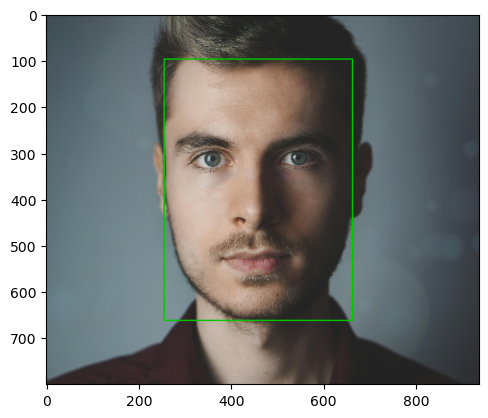

In [96]:
show_image = draw_faceboxes(image, face_boxes, scores)

plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

In [97]:
cv2.imshow("Image", show_image)
cv2.waitKey()
cv2.destroyAllWindows()